In [1]:
from mocpy import MOC
from mocpy.spatial.utils import make_wcs
import numpy as np

%matplotlib inline
import matplotlib.patches as patches
from matplotlib import path

from astropy import units as u

from astropy_healpix import HEALPix
from astropy.coordinates import ICRS, Galactic

from spherical_geometry.polygon import SphericalPolygon
from spherical_geometry import great_circle_arc
from spherical_geometry import vector

In [2]:
def plot(moc):
    import matplotlib.pyplot as plt
    # MOCPy offers a way to easily create an `astropy.wcs.WCS` object.
    # This define an ICRS aitoff projection.
    wcs = make_wcs(crpix=[0, 0], crval=[0, 0], cdelt=[-5, 5], ctype=["RA---AIT", "DEC--AIT"])

    # Create an mpl axe
    fig, ax = plt.subplots(1, 1, figsize=(15, 15), subplot_kw={"projection": wcs})

    # Calls to `mocpy.MOC.fill` for each of the three MOCs with various mpl styling keywords
    # to differentiate them from each other.
    moc.fill(ax=ax, wcs=wcs, edgecolor='g', facecolor='g', linewidth=1.0, fill=True, alpha=0.5)
    
    plt.axis('equal')
    plt.xlabel('ra')
    plt.ylabel('dec')

    plt.title('from polygon')
    plt.grid(color="black", linestyle="dotted")
    plt.legend(loc='upper left')
    plt.show()
    plt.close()
    
def plot_graph(vertices):
    import matplotlib.pyplot as plt
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    p = path.Path(vertices)
    patch = patches.PathPatch(p, facecolor='orange', lw=2)
    ax.add_patch(patch)
    print(vertices)
    lon_min = np.min(vertices[:, 0])
    lon_max = np.max(vertices[:, 0])
    lat_min = np.min(vertices[:, 1])
    lat_max = np.max(vertices[:, 1])
    
    ax.set_xlim(lon_min, lon_max)
    ax.set_ylim(lat_min, lat_max)
    ax.axis('equal')
    plt.show()

[[ 11.98758927  49.23323925]
 [-27.79941534 -27.33697785]
 [-38.74959574  14.37134647]
 [-27.60982747  26.15164278]
 [-25.87062164  14.65927525]
 [ 25.68102339 -32.40263042]
 [ 11.98758927  49.23323925]]


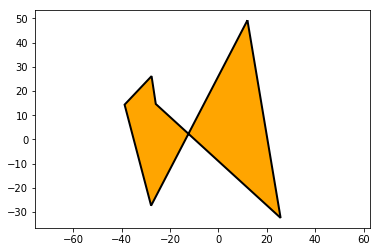

In [3]:
# Define random lon, lat quantities
def get_random_quantities(num_points):
    lon_min, lon_max = (-50, 50)
    lat_min, lat_max = (-50, 50)
    lon = (np.random.random(num_points) * (lon_max - lon_min) + lon_min) * u.deg
    lat = (np.random.random(num_points) * (lat_max - lat_min) + lat_min) * u.deg
    
    vertices = np.vstack((lon.to_value(), lat.to_value())).T
    return vertices

vertices = get_random_quantities(6)
vertices = np.append(vertices, [vertices[0]], axis=0)

plot_graph(vertices)

from astropy.coordinates import SkyCoord
skycoord = SkyCoord(ra=vertices[:, 0], dec=vertices[:, 1], unit="deg", frame="icrs")
inside = SkyCoord(ra=0, dec=0, unit="deg", frame="icrs")

In [4]:
def from_polygon(vertices, inside=None, max_depth=10):    
    def poly_crossing_ipix(poly, ipix):
            # ipix and poly are spherical shapes
            poly_points = list(poly.points)[0]
            x_poly, y_poly, z_poly = (poly_points[:, 0], poly_points[:, 1], poly_points[:, 2])

            ipix_points = list(ipix.points)[0]
            x_ipix, y_ipix, z_ipix = (ipix_points[:, 0], ipix_points[:, 1], ipix_points[:, 2])

            A_poly = np.stack((x_poly, y_poly, z_poly)).T
            B_poly = A_poly
            B_poly = np.append(B_poly, [B_poly[1]], axis=0)
            B_poly = B_poly[1:]

            A_poly = A_poly[:-1]
            B_poly = B_poly[:-1]

            for i in range(len(ipix_points) - 1):
                A_ipix = (x_ipix[i], y_ipix[i], z_ipix[i])
                B_ipix = (x_ipix[i+1], y_ipix[i+1], z_ipix[i+1])

                inter = great_circle_arc.intersects(A_poly, B_poly, A_ipix, B_ipix)
                if inter.any():
                    return True
            return False

    def poly_contains_ipix_vertices(poly, ipix):
        # Get the ipix polygon vertices as a Nx3 numpy array
        # Remove the last vertex as it counts double (closed polygon)
        ipix_vertices = list(ipix.points)[0][:-1, :]
        
        for ipix_vertex in ipix_vertices:
            if not poly.contains_point(ipix_vertex):
                return False
        
        return True
        
        
    def polygon_contains_ipix(poly, ipix):
        if poly_contains_ipix_vertices(ipix, poly):
            return False
        
        return poly_contains_ipix_vertices(poly, ipix) and \
         not poly_crossing_ipix(poly, ipix)
         

    def getStartingDepth(poly):
        def maxDistCenterToVertex(depth):
            nside = (1 << depth)

            lat1 = np.arcsin(2/3)
            lat2 = np.arcsin(1 - ((1 - 1/nside)**2 / 3))
            lon1 = np.pi/4 * 1 / nside
            lon2 = 0
            
            n1 = np.asarray(vector.lonlat_to_vector(lon=lon1, lat=lat1, degrees=False))
            n2 = np.asarray(vector.lonlat_to_vector(lon=lon2, lat=lat2, degrees=False))
            print(n1, n2)
            vector.normalize_vector(n1, output=n1)
            vector.normalize_vector(n2, output=n2)
            
            return np.arctan(np.linalg.norm(np.cross(n1, n2))/np.dot(n1, n2))
            
        # Get the polygon vertices as a Nx3 numpy array
        # Remove the last vertex as it counts double (closed polygon)
        p_vertices = np.asarray(list(poly.points))[0][:-1, :]
        # Get the center formed by the vertices
        center = p_vertices.mean(axis=0)
        # Normalize it so that it lies on the unit sphere
        vector.normalize_vector(center, output=center)
        center = np.asarray(center)
        print("center: ", center)
        print("poly points: ", p_vertices)
        # Compute the maximum angular distance between the polygon vertices 
        # and its center. This refers to the Vector version of the
        # Great-circle distance computation.
        #
        # See https://en.wikipedia.org/wiki/Great-circle_distance
        max_d = -1;
        for vertex in p_vertices:
            d = np.arctan(np.linalg.norm(np.cross(center, vertex))/np.dot(center, vertex)) # in rad
            if d > max_d:
                max_d = d
        
        # Return the min depth so that max_d > max_center_to_vertex_ipix(depth)
        depth = 0
        while maxDistCenterToVertex(depth) >= max_d:
            depth = depth + 1
        
        # Get the ipixels from astropy_healpix covering the cone of (center, radius) = (center, max_d)
        lon_center, lat_center = vector.vector_to_lonlat(x=center[0], y=center[1], z=center[2], degrees=False)
        hp = HEALPix(nside=(1 << depth), order='nested', frame=ICRS())
        starting_iter_ipix = hp.cone_search_lonlat(lon=lon_center * u.rad, lat=lat_center * u.rad, radius=max_d * u.rad)
        
        return depth, starting_iter_ipix

    ipix_inter_polygon = np.arange(12)
    ipix_d = {}

    ra = vertices.icrs.ra.deg
    dec = vertices.icrs.dec.deg
    # Check if the vertices form a closed polygon
    if ra[0] != ra[-1] or dec[0] != dec[-1]:
        # If not, append the first vertex to ``vertices``
        ra = np.append(ra, ra[0])
        dec = np.append(dec, dec[0])
        vertices = SkyCoord(ra=ra, dec=dec, unit="deg", frame="icrs")

    if inside:
        # Convert it to (x, y, z) cartesian coordinates on the sphere
        inside = (inside.icrs.ra.deg, inside.icrs.dec.deg)

    polygon = SphericalPolygon.from_lonlat(lon=vertices.icrs.ra.deg, lat=vertices.icrs.dec.deg, center=inside, degrees=True)
    #start_depth, ipix_inter_polygon = getStartingDepth(polygon)
    
    for order in range(max_depth + 1):
        hp = HEALPix(nside=(1 << order), order='nested', frame=ICRS())

        lon, lat = hp.boundaries_lonlat(ipix_inter_polygon, step=1)
        lon = lon.to(u.deg).value
        lat = lat.to(u.deg).value

        shapes = np.vstack((lon.ravel(), lat.ravel())).T.reshape(ipix_inter_polygon.shape[0], 4, -1)
        ipix_in_polygon_l = []
        ipix_l = []
        for i in range(ipix_inter_polygon.shape[0]):
            # Spherical polygon asks for a closed list of vertices. We add its first vertex to the end.
            shape = shapes[i]
            shape = np.append(shape, [shape[0]], axis=0)

            ipix_shape = SphericalPolygon.from_radec(lon=shape[:, 0], lat=shape[:, 1], degrees=True)

            ipix = ipix_inter_polygon[i]
            if polygon.intersects_poly(ipix_shape):
                # If we are at the max depth then we direcly add to the MOC the intersecting ipixels
                if order == max_depth:
                    ipix_in_polygon_l.append(ipix)
                else:
                    # Check whether polygon contains ipix or not
                    if polygon_contains_ipix(polygon, ipix_shape):
                        ipix_in_polygon_l.append(ipix)
                    else:
                        # The ipix is just intersecting without being contained in the polygon
                        # We split it in its 4 children
                        offset = ipix << 2
                        ipix_l.extend([offset, offset+1, offset+2, offset+3])
        
        ipix_d.update({str(order): ipix_in_polygon_l})
        ipix_inter_polygon = np.asarray(ipix_l)

    return MOC.from_json(ipix_d)

No handles with labels found to put in legend.


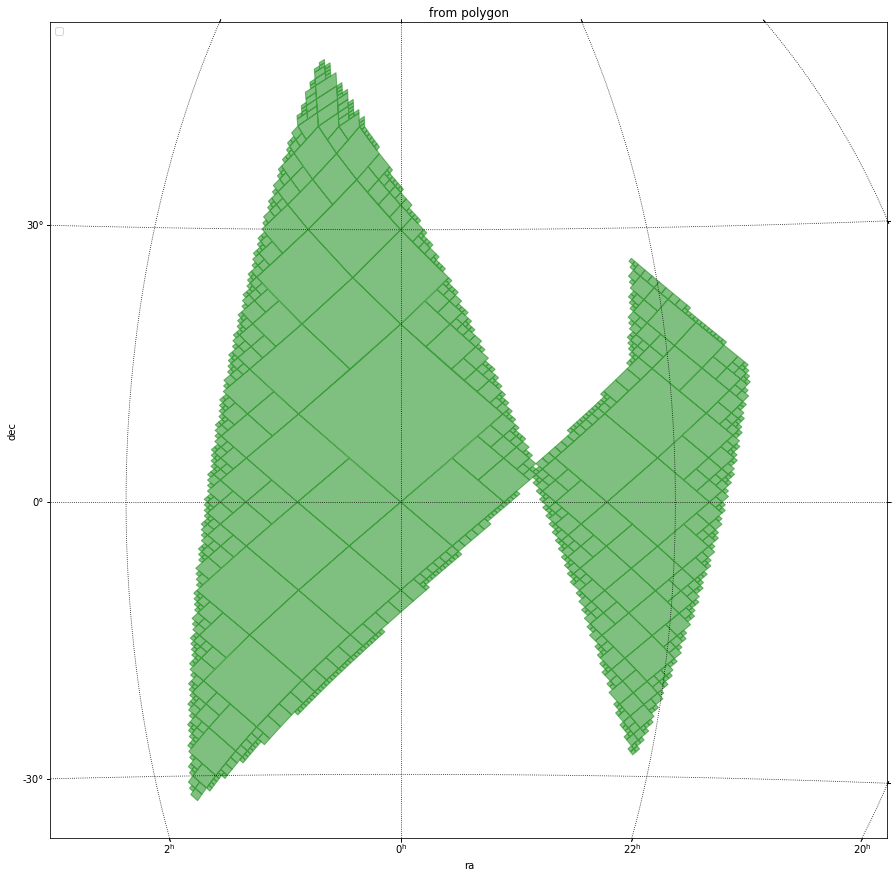

In [5]:
moc = from_polygon(vertices=skycoord, max_depth=7, inside=inside)
plot(moc)